# Simple Affine Coupling layers - RealNVP
This code is optimized for readability, not performance, and so please do not use this for any experiments. Refer to the nflows package for this, as shown in the nflows notebook.

A general method for constructing deep flow networks are the following:
- A composable layer definition
- A method for shuffling the data
- A method for composing many layers of flows
- A distribution from which we can sample, and calculate the log probability of a given sample.

In the following we will implement all four of these steps as classes, and demonstrate how these models can be trained.

In [1]:
# Necessary imports
import torch
import torch.nn as nn
from copy import copy
import numpy as np
from matplotlib import pyplot as plt

Network to learn parameters of the transformation in the flow

In [2]:
# Build a simple dense network for computing scale and translation factors.
class dense_net(nn.Module):
    def __init__(self, nfeatures, output_dim, inner_acitvations, layers=[128, 128, 128]):
        super(dense_net, self).__init__()
        self.inner_acitvation = inner_acitvations
        ll = [nfeatures] + layers + [output_dim]
        self.functions = nn.ModuleList([nn.Linear(ll[i], ll[i + 1]) for i in range(len(ll) - 1)])

    def forward(self, x):
        # Forward transform of the dense network
        for i, function in enumerate(self.functions[:-1]):
            x = function(x)
            x = self.inner_acitvation(x)
        x = self.functions[-1](x)
        return x

Layers that can be stacked together to build the flow.

In [3]:
# Make a coupling layer that will define the building block for our invertible neural network (INN)
class coupling_layer(nn.Module):

    def __init__(self, nfeatures, nmask):
        super(coupling_layer, self).__init__()
        # Save the number of features to mask
        self.nmask = nmask

        #### Define the networks for scale and shifting the input to the layer. Note that neither have an output activation. ####
        # Here relu activations typically work well - from empirical observations
        self.translate_net = dense_net(nmask, nfeatures - nmask, torch.relu)
        # Here tanh activations typically work well - from empirical observations
        self.scale_net = dense_net(nmask, nfeatures - nmask, torch.tanh)

    # Define a transformation that forms part of the flow, 'pointing' from the data distribution to the base distribution
    # 'pointing' means that this method is called as part of a chain when propogating samples from data towards the base distribution.
    def forward(self, x):
        # We take the last (nfeatures - nmask) features as those that will be transformed/masked
        # The first nmask features are passed through, but are used to define the transformation
        x_pass, x_mask = torch.split(x, self.nmask, 1)
        # The log determinant will be the sum of the logarithm of the output of this network
        log_s = self.scale_net(x_pass)
        # The translation is unbounded, so no output activation. 
        t_fact = self.translate_net(x_pass)
        # We have defined the output of scale_net to be the log of s
        s_fact = torch.exp(log_s)
        # Transform the last nfeatures - nmask features and 'pass' through the first nmask
        transform = torch.cat((x_pass, x_mask * s_fact + t_fact), 1)
        # The log determinant is the sum of the log of each output
        log_det = log_s.sum(-1, keepdim=True)
        return transform, log_det

    # Define in the other direction, 'pointing' from the base distribution to the data distribution
    # Note that in most packages/implementations this is implemented with a keyword passed to forward
    def inverse(self, x):
        x_pass, x_mask = torch.split(x, self.nmask, 1)
        log_s = self.scale_net(x_pass)
        t_fact = self.translate_net(x_pass)
        # The inverse of the exponential is the negative of the exponential
        s_fact = torch.exp(-log_s)
        # Get the inverse transform
        inverse_transform = torch.cat((x_pass, (x_mask - t_fact) * s_fact), 1)
        # The log determinant is the sum of the log of each output, we again multiply by -1 as we take the inverse of the exponential
        log_det = -log_s.sum(-1, keepdim=True)
        return inverse_transform, log_det

In [4]:
# Make a layer that will shuffle the data such that we apply our above coupling layer to a different input at each step
# Taken from the nflows package, this isn't a very interesting piece of the puzzle.
# The specific implementation is not something to focus on, all this does is flip the ordering of the input to the layer
# The important thing to note is that the log abs det contributes nothing to the total determinant
class reverse_permute(nn.Module):

    def __init__(self, nfeatures, dim=1):
        super(reverse_permute, self).__init__()
        # Save the number of features to mask
        self._dim = dim
        self.nmask = nfeatures
        self.register_buffer("_permutation", torch.arange(nfeatures - 1, -1, -1))

    @property
    def _inverse_permutation(self):
        return torch.argsort(self._permutation)

    @staticmethod
    def _permute(inputs, permutation, dim):
        outputs = torch.index_select(inputs, dim, permutation)
        # Note here that the contribution the the log determinant is zero
        # The determinant of the matrix is one, so the log is zero.
        # This means that it contributes nothing to the sum of the cascade of transformations
        logabsdet = inputs.new_zeros((inputs.shape[0], dim))
        return outputs, logabsdet

    def forward(self, inputs, context=None):
        return self._permute(inputs, self._permutation, self._dim)

    def inverse(self, inputs, context=None):
        return self._permute(inputs, self._inverse_permutation, self._dim)

The base distribution

In [ ]:
# We also need a distribution which has a log probability method and can be sampled from
class StandardNormal():

    def __init__(self, shape):
        self._shape = torch.Size(shape)

    def log_prob(self, inputs):
        # Return the log probability of a given sample under a standard normal distribution
        return (-0.5 * inputs.pow(2) - 0.5 * np.log(2 * np.pi)).sum(-1, keepdim=True)

    def sample(self, num_samples):
        # Sample from a standard normal
        return torch.randn(num_samples, *self._shape)

The flow object itself

In [5]:
# Now we will make the flow object that can be used for training
class AffineCouplingFlow(nn.Module):

    def __init__(self, nfeatures, nmask, base_distribution, nstack=3):
        super(AffineCouplingFlow, self).__init__()
        # Construct a stack of coupling and permutation layers for training
        layer_list = []
        for _ in range(nstack):
          layer_list += [coupling_layer(nfeatures, nmask), reverse_permute(nfeatures)]
        # Register all but the last permutation layer for training
        self.coupling_layers = nn.ModuleList(layer_list[:-1])
        # Used to calculate the log_prob in self.log_probs, and also in sampling
        self.base_distribution = base_distribution
        # Normally we would want to pass variable types of permutation and coupling layers,
        # but here, for illustration, we leave this step out.

    # Propogate transformation from data to base distribution
    def forward(self, inputs):
        log_det = torch.zeros(inputs.size(0), 1, device=inputs.device)
        for layer in self.coupling_layers:
            inputs, ld = layer(inputs)
            log_det += ld
        return inputs, log_det

    # Propogate transformation from base distribution to data, note that the only
    # difference is that we call the inverse method of each layer
    def inverse(self, inputs):
        log_det = torch.zeros(inputs.shape[0], 1, device=inputs.device)
        for layer in self.coupling_layers[::-1]:
            inputs, ld = layer.inverse(inputs)
            log_det += ld
        return inputs, log_det

    def log_prob(self, inputs, cond_inputs=None):
        # Get the transformed inputs as well as the determinant of the jacobian
        output, log_det_jacobian = self(inputs)
        # Get the log probability - of the output of the transformation - under the base distribution
        log_probs = self.base_distribution.log_prob(output)
        # Use the change of variables formula and take the average
        return (log_probs + log_det_jacobian).mean()

    def sample(self, nsamp):
        # Get the device the model is currently on
        device = next(self.parameters()).device
        print(device)
        # Get a sample from the base distribtion and send to device
        bdist_sample = self.base_distribution.sample(nsamp).to(device)
        # Call the inverse method and only take the first returned value
        samples = self.inverse(bdist_sample)[0]
        return samples

# Build the flow


In [7]:
# Get the current device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Our flow is now defined in terms of a base distribution and the coupling layers.
flow = AffineCouplingFlow(2, 1, StandardNormal([2]), nstack=5).to(device)

Explore how the flow is initialized

In [8]:
# A simple utility for plotting 2D histograms
def plot2Dhist(data, bins=50, bounds=None):
    fig, ax = plt.subplots(1, figsize=(5,5))
    data = data.detach().cpu().numpy()
    x = data[:, 0]
    y = data[:, 1]
    count, xbins, ybins = np.histogram2d(x, y, bins=bins)
    count[count == 0] = np.nan
    ax.imshow(count.T,
              origin='lower', aspect='auto',
              extent=[xbins.min(), xbins.max(), ybins.min(), ybins.max()],
              )

cpu


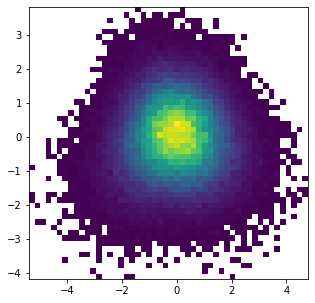

In [9]:
nsamp = int(1e5)
# Draw a sample from the flow
sample = flow.sample(nsamp)
# plot the sample
plot2Dhist(sample)

# Train on data
Now we need to load/generate a dataset and train our flow on it. Here we will use data from the neural spline flows ([NSF](https://github.com/bayesiains/nsf/blob/master/data/plane.py)) repository.


In [10]:
# Here we will build and sample our own dataset, understanding this code is not relevant, 
# but it is simple if you want to understand it
from torch.utils.data import Dataset

class PlaneDataset(Dataset):
    def __init__(self, num_points, flip_axes=False):
        self.num_points = num_points
        self.flip_axes = flip_axes
        self.data = None
        self.reset()

    def __getitem__(self, item):
        return self.data[item]

    def __len__(self):
        return self.num_points

    def reset(self):
        self._create_data()
        if self.flip_axes:
            x1 = self.data[:, 0]
            x2 = self.data[:, 1]
            self.data = torch.stack([x2, x1]).t()

    def _create_data(self):
        raise NotImplementedError


class CrescentDataset(PlaneDataset):
    def _create_data(self):
        self.bounded = False
        x1 = torch.randn(self.num_points)
        x2_mean = 0.5 * x1 ** 2 - 1
        x2_var = torch.exp(torch.Tensor([-2]))
        x2 = x2_mean + x2_var ** 0.5 * torch.randn(self.num_points)
        self.data = torch.stack((x2, x1)).t()

In [11]:
# Here we will build the dataset that we will train on
ndata = int(1e5)
dataset = CrescentDataset(ndata)
# The data is accessed through .data and sent to the device like this
data = dataset.data.to(device)

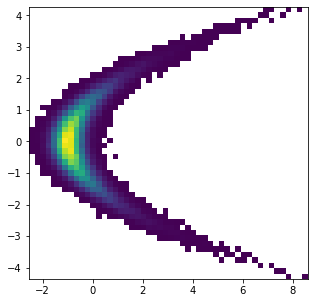

In [12]:
# Visualize the dataset
plot2Dhist(data)

In [13]:
import torch.optim as optim

batch_size = 64
nepochs = 20

# Make an object to load training data
data_obj = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

# Make an optimizer object
optimizer = optim.SGD(flow.parameters(), lr=0.001, momentum=0.9)

for epoch in range(nepochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(data_obj, 0):

        # zero the parameter gradients
        optimizer.zero_grad()

        # We want to maximize this, and so we minimize the negative
        loss = -flow.log_prob(data.to(device))
        # Propogate the loss
        loss.backward()
        # Update the parameters
        optimizer.step()

        # print statistics of the loss - simplest training loop
        running_loss += loss.item()
        if i % 200 == 199:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,   200] loss: 0.214
[1,   400] loss: 0.188
[1,   600] loss: 0.187
[1,   800] loss: 0.186
[1,  1000] loss: 0.188
[1,  1200] loss: 0.187
[1,  1400] loss: 0.186
[2,   200] loss: 0.185
[2,   400] loss: 0.186
[2,   600] loss: 0.184
[2,   800] loss: 0.186
[2,  1000] loss: 0.186
[2,  1200] loss: 0.185
[2,  1400] loss: 0.183
[3,   200] loss: 0.184
[3,   400] loss: 0.185
[3,   600] loss: 0.186
[3,   800] loss: 0.185
[3,  1000] loss: 0.185
[3,  1200] loss: 0.185
[3,  1400] loss: 0.185
[4,   200] loss: 0.185
[4,   400] loss: 0.183
[4,   600] loss: 0.185
[4,   800] loss: 0.186
[4,  1000] loss: 0.185
[4,  1200] loss: 0.184
[4,  1400] loss: 0.185
[5,   200] loss: 0.185
[5,   400] loss: 0.184
[5,   600] loss: 0.185
[5,   800] loss: 0.184
[5,  1000] loss: 0.186
[5,  1200] loss: 0.184
[5,  1400] loss: 0.185
[6,   200] loss: 0.186
[6,   400] loss: 0.183
[6,   600] loss: 0.184
[6,   800] loss: 0.185
[6,  1000] loss: 0.184
[6,  1200] loss: 0.185
[6,  1400] loss: 0.184
[7,   200] loss: 0.184
[7,   400] 

cpu


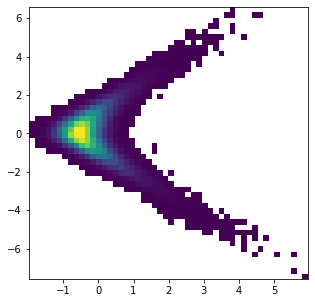

In [14]:
# Now we can visualize what the model has learned by drawing samples from the model
nsamp = int(1e5)
plot2Dhist(flow.sample(nsamp))

And we are done! We have built and trained a simple coupling flow. 

\
Now, to change this architecture we just have to replace/redefine coupling layers to be more flexible, or add context. 

To have a different base distribution we can just define a different distribution class.  

We might also want to add functionality, like mapping the dataset to the base distribution.

\
Doing all of this by hand is time consuming, but worthwhile. However there is a useful package that takes care of most of the admin for us, this is what we will look at next.